#### Imports and initialization

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime, timedelta

import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Import TimeseriesGenerator from keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Set random seed for reproducibility
np.random.seed(228)

#### Step 1: Data loading and examination

In [4]:
# Load the power generation data
power_df = pd.read_csv('Plant_1_Generation_Data.csv')

# Load the weather sensor data
weather_df = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')

In [5]:
print("\nPower Generation Data - Shape:", power_df.shape)
print(power_df.head())


Power Generation Data - Shape: (68778, 7)
          DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
0  15-05-2020 00:00   4135001  1BY6WEcLGh8j5v7       0.0       0.0   
1  15-05-2020 00:00   4135001  1IF53ai7Xc0U56Y       0.0       0.0   
2  15-05-2020 00:00   4135001  3PZuoBAID5Wc2HD       0.0       0.0   
3  15-05-2020 00:00   4135001  7JYdWkrLSPkdwr4       0.0       0.0   
4  15-05-2020 00:00   4135001  McdE0feGgRqW7Ca       0.0       0.0   

   DAILY_YIELD  TOTAL_YIELD  
0          0.0    6259559.0  
1          0.0    6183645.0  
2          0.0    6987759.0  
3          0.0    7602960.0  
4          0.0    7158964.0  


In [6]:
print("\nWeather Sensor Data - Shape:", weather_df.shape)
print(weather_df.head())


Weather Sensor Data - Shape: (3182, 6)
             DATE_TIME  PLANT_ID       SOURCE_KEY  AMBIENT_TEMPERATURE  \
0  2020-05-15 00:00:00   4135001  HmiyD2TTLFNqkNe            25.184316   
1  2020-05-15 00:15:00   4135001  HmiyD2TTLFNqkNe            25.084589   
2  2020-05-15 00:30:00   4135001  HmiyD2TTLFNqkNe            24.935753   
3  2020-05-15 00:45:00   4135001  HmiyD2TTLFNqkNe            24.846130   
4  2020-05-15 01:00:00   4135001  HmiyD2TTLFNqkNe            24.621525   

   MODULE_TEMPERATURE  IRRADIATION  
0           22.857507          0.0  
1           22.761668          0.0  
2           22.592306          0.0  
3           22.360852          0.0  
4           22.165423          0.0  


In [7]:
print("\nMissing values in Power Generation Data:")
print(power_df.isnull().sum())


Missing values in Power Generation Data:
DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64


In [8]:
print("\nMissing values in Weather Sensor Data:")
print(weather_df.isnull().sum())


Missing values in Weather Sensor Data:
DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64


#### Step 2: Data preprocessing

In [9]:
# Convert DATE_TIME to datetime format for both datasets
power_df['DATE_TIME'] = pd.to_datetime(power_df['DATE_TIME'])
weather_df['DATE_TIME'] = pd.to_datetime(weather_df['DATE_TIME'])

C:\Users\nikit\AppData\Local\Temp\ipykernel_40968\2302564641.py:2: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  power_df['DATE_TIME'] = pd.to_datetime(power_df['DATE_TIME'])


In [10]:
# Let's find the most common SOURCE_KEY
most_common_source = power_df['SOURCE_KEY'].value_counts().index[0]
print(f"\nMost common SOURCE_KEY: {most_common_source}")


Most common SOURCE_KEY: bvBOhCH3iADSZry


In [11]:
# Filter data for the most common source
source_power_df = power_df[power_df['SOURCE_KEY'] == most_common_source]

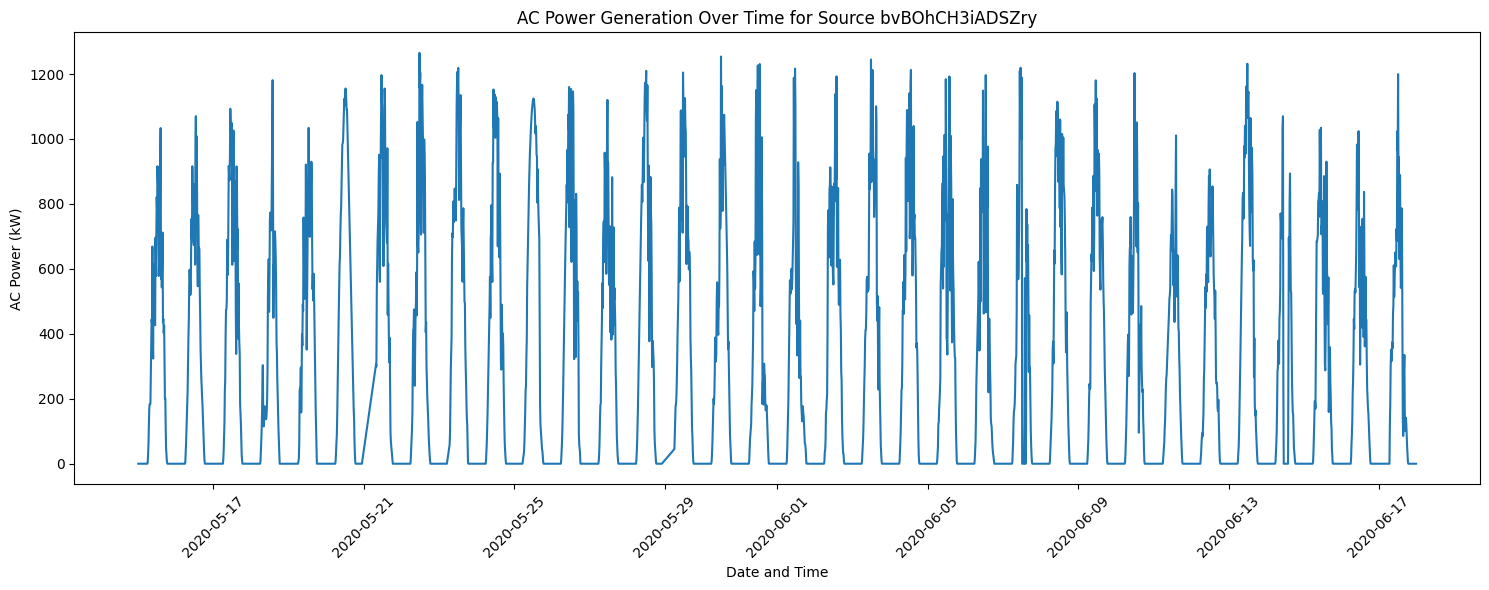

In [12]:
# Visualize AC_POWER over time
plt.figure(figsize=(15, 6))
plt.plot(source_power_df['DATE_TIME'], source_power_df['AC_POWER'])
plt.title(f'AC Power Generation Over Time for Source {most_common_source}')
plt.xlabel('Date and Time')
plt.ylabel('AC Power (kW)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
# Merge power and weather data
merged_df = pd.merge(power_df, weather_df, on=['DATE_TIME', 'PLANT_ID'], how='inner', suffixes=('_power', '_weather'))
print(f"Merged dataframe shape: {merged_df.shape}")

Merged dataframe shape: (68774, 11)


In [14]:
# Extract time features
merged_df['hour'] = merged_df['DATE_TIME'].dt.hour
merged_df['day'] = merged_df['DATE_TIME'].dt.day
merged_df['day_of_week'] = merged_df['DATE_TIME'].dt.dayofweek

In [15]:
# Create a combined dataframe for a single source
source_df = merged_df[merged_df['SOURCE_KEY_power'] == most_common_source].copy()

In [16]:
# Select relevant columns for forecasting
forecast_df = source_df[['DATE_TIME', 'AC_POWER', 'AMBIENT_TEMPERATURE', 
                        'MODULE_TEMPERATURE', 'IRRADIATION', 
                        'hour', 'day', 'day_of_week']].copy()

In [17]:
# Handle missing values
forecast_df = forecast_df.fillna(method='ffill')
forecast_df = forecast_df.fillna(method='bfill')

C:\Users\nikit\AppData\Local\Temp\ipykernel_40968\2064421727.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  forecast_df = forecast_df.fillna(method='ffill')
C:\Users\nikit\AppData\Local\Temp\ipykernel_40968\2064421727.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  forecast_df = forecast_df.fillna(method='bfill')


In [18]:
# Scale the features
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

In [19]:
# Define feature columns and scale them
feature_columns = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'hour', 'day', 'day_of_week']
forecast_df[feature_columns] = scaler_features.fit_transform(forecast_df[feature_columns])
forecast_df[['AC_POWER']] = scaler_target.fit_transform(forecast_df[['AC_POWER']])

#### Step 3: Split data into training and test sets

In [20]:
# Parameters for time series forecasting
look_back = 96  # 24 hours with 15-minute intervals
n_features = 7  # AC_POWER + 6 feature columns

In [21]:
# Extract our features and target as numpy arrays
ac_power = forecast_df['AC_POWER'].values
features = forecast_df[['AC_POWER'] + feature_columns].values

In [22]:
# Split into training and testing sets (80% train, 20% test)
split_point = int(len(features) * 0.8)
train_features = features[:split_point]
test_features = features[split_point:]

In [24]:
# Create TimeseriesGenerators for training and testing
train_generator = TimeseriesGenerator(
    train_features, train_features[:, 0],  # Features and target (AC_POWER)
    length=look_back,
    batch_size=32
)

test_generator = TimeseriesGenerator(
    test_features, test_features[:, 0],  # Features and target (AC_POWER)
    length=look_back,
    batch_size=32
)

In [25]:
print(f"Number of training batches: {len(train_generator)}")
print(f"Number of testing batches: {len(test_generator)}")

Number of training batches: 76
Number of testing batches: 17


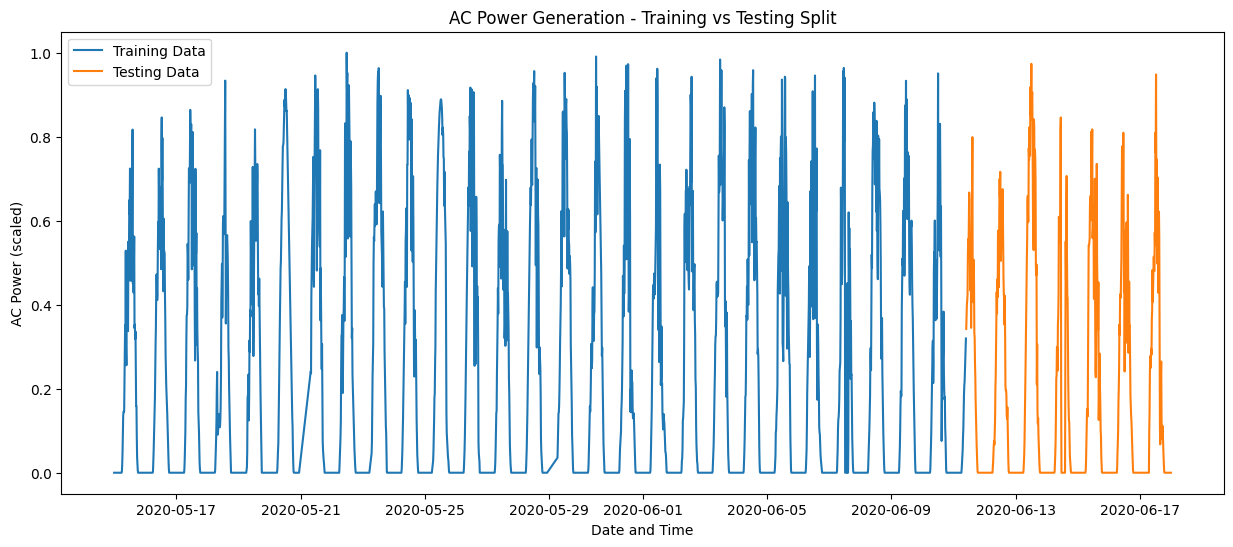

In [28]:
# Visualize the training and testing data split
plt.figure(figsize=(15, 6))
plt.plot(forecast_df['DATE_TIME'][:split_point], ac_power[:split_point], label='Training Data')
plt.plot(forecast_df['DATE_TIME'][split_point:], ac_power[split_point:], label='Testing Data')
plt.title('AC Power Generation - Training vs Testing Split')
plt.xlabel('Date and Time')
plt.ylabel('AC Power (scaled)')
plt.legend()
plt.show()

#### Step 4: Build LSTM model and train it

In [30]:
# Define the LSTM model
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(look_back, n_features)),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for next value prediction
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Display model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 96, 64)         │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 96, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
model_checkpoint = ModelCheckpoint('best_solar_model.keras', save_best_only=True)

In [32]:
# Train the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/100


c:\Users\nikit\Documents\MachineLearning\deep-learning-course\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0851 - val_loss: 0.0205 - learning_rate: 0.0010
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0280 - val_loss: 0.0149 - learning_rate: 0.0010
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0169 - val_loss: 0.0130 - learning_rate: 0.0010
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0157 - val_loss: 0.0111 - learning_rate: 0.0010
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0174 - val_loss: 0.0115 - learning_rate: 0.0010
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0127 - val_loss: 0.0133 - learning_rate: 0.0010
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0119 - val_loss: 0.0105 - learning_rate: 0.0010
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0145 - val_loss: 0.0107 - learning_rate: 0.0010
Epoch 9/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0131 - val_loss: 0.0100 - learning_rate: 0.0010
Epoch 10/100
76/76 ━━━

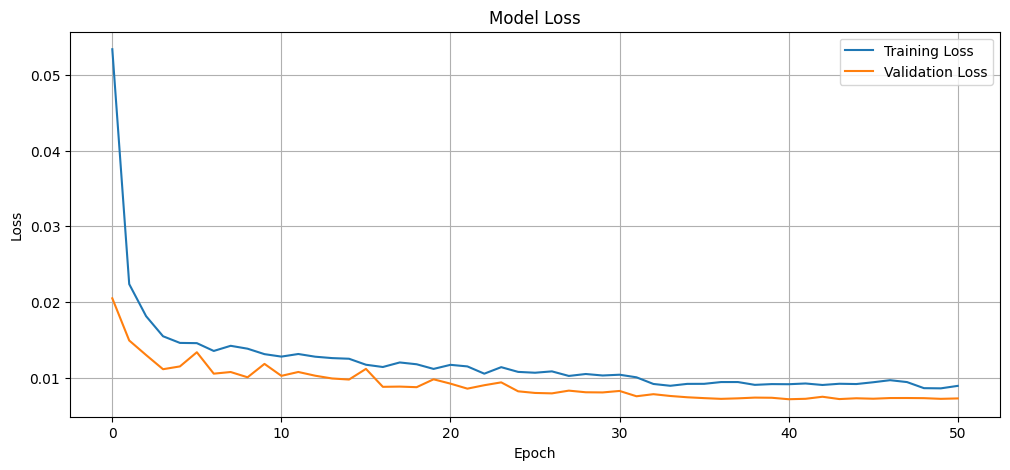

In [33]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Step 5: Use model on the test data and show error metrics

In [34]:
# Get predictions on test data
test_predictions = []

# Similar to the example code, we'll predict each batch
for i in range(len(test_generator)):
    x, _ = test_generator[i]
    pred = model.predict(x, verbose=0)
    test_predictions.extend(pred.flatten())

# Extract actual test values for comparison
test_targets = test_features[look_back:look_back+len(test_predictions), 0]

# Invert scaling for comparison
test_predictions_inv = scaler_target.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()
test_targets_inv = scaler_target.inverse_transform(test_targets.reshape(-1, 1)).flatten()

In [35]:
# Calculate error metrics
mae = mean_absolute_error(test_targets_inv, test_predictions_inv)
mse = mean_squared_error(test_targets_inv, test_predictions_inv)
rmse = np.sqrt(mse)
r2 = r2_score(test_targets_inv, test_predictions_inv)

print(f"Mean Absolute Error (MAE): {mae:.2f} kW")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} kW")
print(f"R-squared (R²): {r2:.4f}")

Mean Absolute Error (MAE): 58.53 kW
Root Mean Squared Error (RMSE): 106.89 kW
R-squared (R²): 0.8986


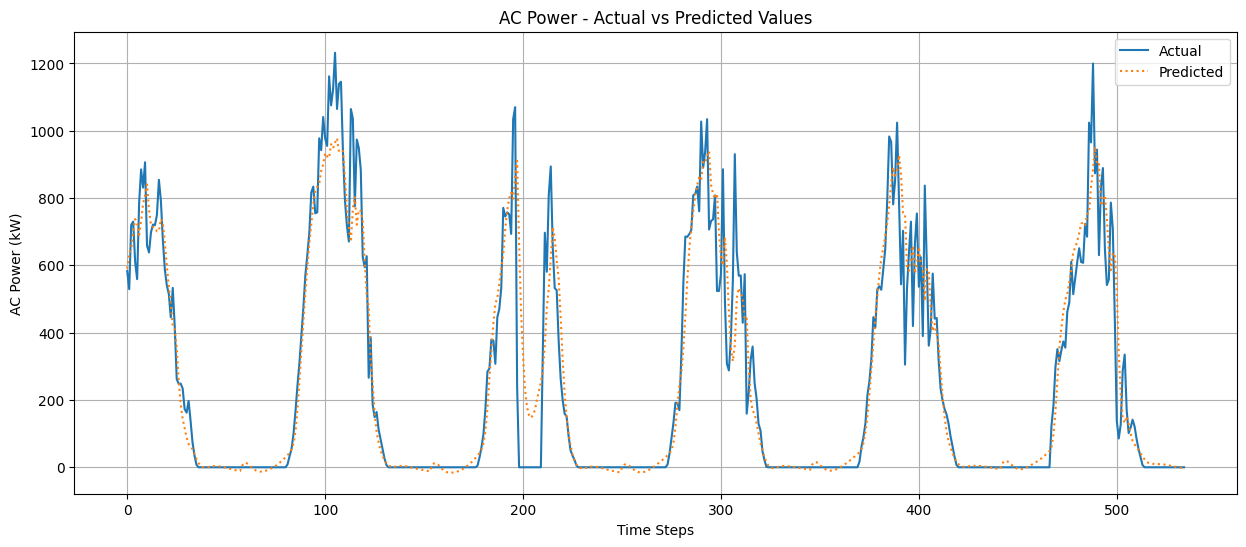

In [36]:
# Plot predictions vs actual values
plt.figure(figsize=(15, 6))
plt.plot(test_targets_inv, label='Actual')
plt.plot(test_predictions_inv, label='Predicted', linestyle=':')
plt.title('AC Power - Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('AC Power (kW)')
plt.legend()
plt.grid(True)
plt.show()

#### Step 6: Forecasting into the future

In [51]:
# Following the example notebook approach for extrapolation
extrapolation = []

# Use the last sequence from the test data as seed
seed_batch = test_features[-look_back:].reshape(1, look_back, n_features)
current_batch = seed_batch.copy()

# Number of steps to forecast (24 hours ahead = 96 steps with 15-min intervals)
forecast_steps = 96

# Get the last timestamp and create a range of future timestamps
last_date = forecast_df['DATE_TIME'].iloc[-1]
forecast_dates = pd.date_range(
    start=last_date + pd.Timedelta(minutes=15),
    periods=forecast_steps,
    freq='15min'
)

In [52]:
# Create a recursive forecast
for i in range(forecast_steps):
    # Predict the next value
    next_pred = model.predict(current_batch, verbose=0)[0, 0]
    extrapolation.append(next_pred)
    
    # Get the next timestamp's hour, day, day of week
    next_date = forecast_dates[i]
    next_hour = next_date.hour / 24.0  # Scale to [0,1] range
    next_day = next_date.day / 31.0    # Scale approximately to [0,1]
    next_dow = next_date.dayofweek / 6.0  # Scale to [0,1]
    
    # Update the batch for next prediction by shifting values
    next_row = current_batch[0, -1:, :].copy()
    
    # Update all features
    next_row[0, 0] = next_pred               # AC_POWER
    # Keep weather features as they were, or use a simple model to update them
    # next_row[0, 1:4] stays the same
    next_row[0, 4] = next_hour               # hour
    next_row[0, 5] = next_day                # day
    next_row[0, 6] = next_dow                # day_of_week
    
    # Slide the window by removing the oldest entry and adding the new prediction
    current_batch = np.append(current_batch[:, 1:, :], next_row.reshape(1, 1, n_features), axis=1)

# Print some values to check if they're varying
print("Sample of extrapolation values:")
print(extrapolation[:10])  # First 10 values

Sample of extrapolation values:
[np.float32(-0.00302656), np.float32(0.008512825), np.float32(0.015626565), np.float32(0.017715171), np.float32(0.01639153), np.float32(0.012891233), np.float32(0.008948535), np.float32(0.005276099), np.float32(0.0022183955), np.float32(-0.0003681183)]


In [53]:
# Convert predictions back to original scale
extrapolation_inv = scaler_target.inverse_transform(np.array(extrapolation).reshape(-1, 1)).flatten()

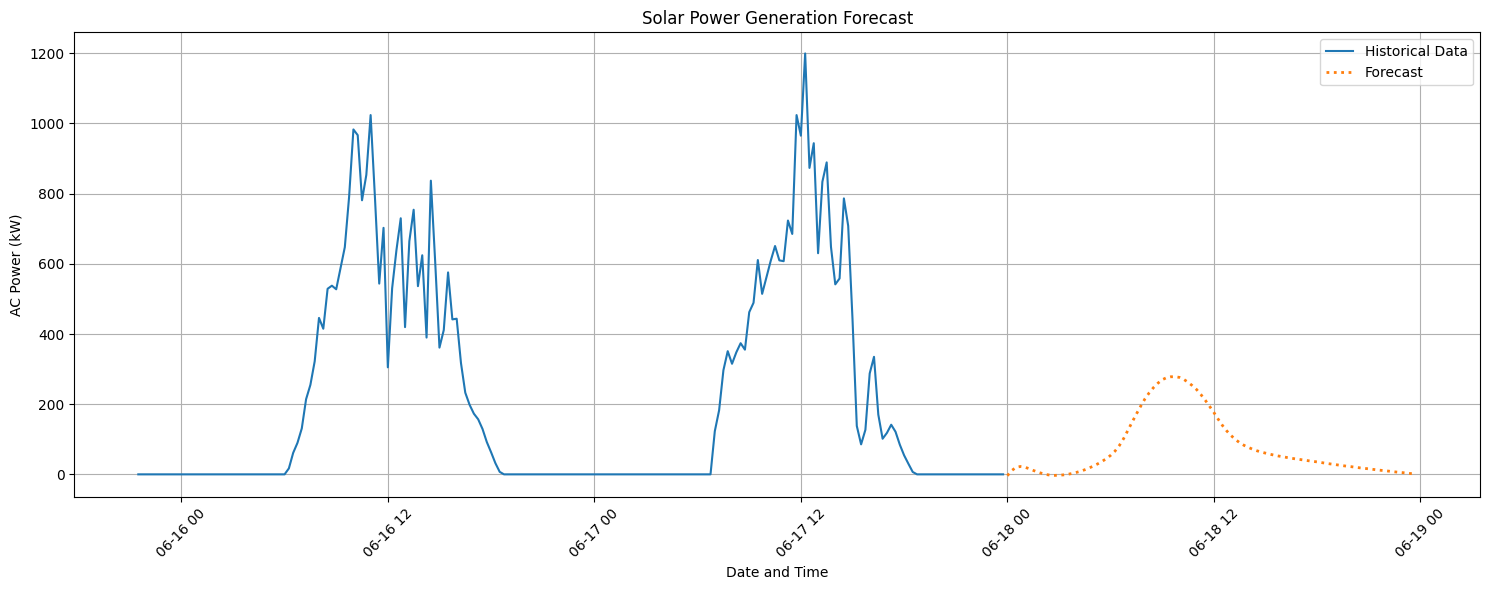

In [54]:
# Plot the historical data and the forecast
plt.figure(figsize=(15, 6))
# Plot the last portion of historical data
recent_history_size = 200  # Number of historical points to show
recent_dates = forecast_df['DATE_TIME'].iloc[-recent_history_size:]
recent_values = scaler_target.inverse_transform(features[-recent_history_size:, 0].reshape(-1, 1)).flatten()

plt.plot(recent_dates, recent_values, label='Historical Data')
plt.plot(forecast_dates, extrapolation_inv, label='Forecast', linestyle=':', linewidth=2)
plt.title('Solar Power Generation Forecast')
plt.xlabel('Date and Time')
plt.ylabel('AC Power (kW)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

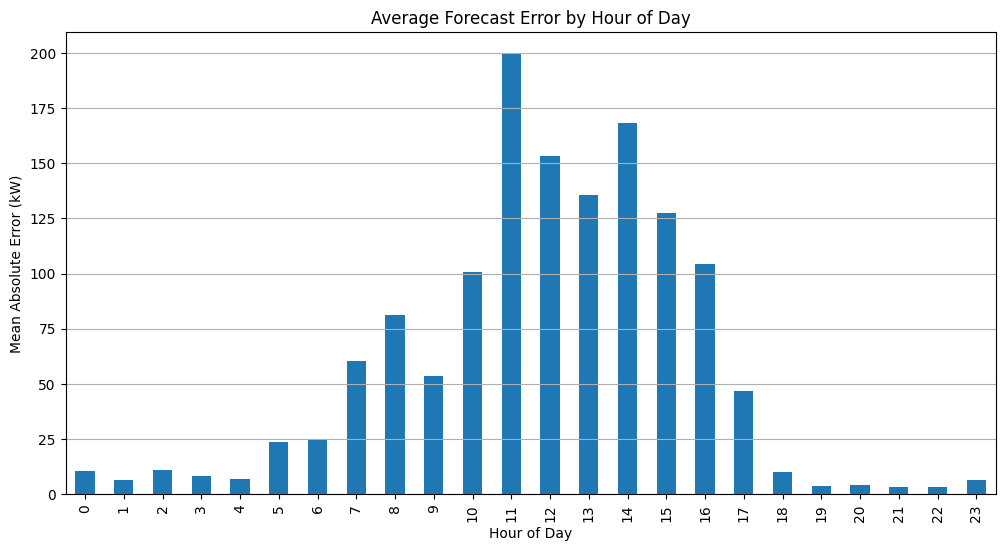

Average error during daytime (6 AM - 7 PM): 99.98 kW
Average error during nighttime: 7.59 kW
The model is more accurate during night hours.


In [57]:
# Let's analyze how well our model handles different times of day
# by grouping forecast errors by hour

# Extract hour of day for each point in the test dataset
test_hours = forecast_df['DATE_TIME'][split_point+look_back:split_point+look_back+len(test_predictions)].dt.hour

# Calculate absolute errors
abs_errors = np.abs(test_predictions_inv - test_targets_inv)

# Create a DataFrame to analyze errors by hour
hourly_errors = pd.DataFrame({
    'Hour': test_hours,
    'AbsError': abs_errors
})

# Calculate average error by hour
hourly_avg_errors = hourly_errors.groupby('Hour')['AbsError'].mean()

# Plot errors by hour of day
plt.figure(figsize=(12, 6))
hourly_avg_errors.plot(kind='bar')
plt.title('Average Forecast Error by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Absolute Error (kW)')
plt.grid(axis='y')
plt.show()

# Analyze how the model performs during day vs night
day_hours = range(6, 19)  # 6 AM to 7 PM
night_hours = list(range(0, 6)) + list(range(19, 24))  # Night hours

day_errors = hourly_errors[hourly_errors['Hour'].isin(day_hours)]['AbsError'].mean()
night_errors = hourly_errors[hourly_errors['Hour'].isin(night_hours)]['AbsError'].mean()

print(f"Average error during daytime (6 AM - 7 PM): {day_errors:.2f} kW")
print(f"Average error during nighttime: {night_errors:.2f} kW")
print(f"The model is {'more' if day_errors > night_errors else 'less'} accurate during night hours.")

#### Step 7: Personal Analysis and Insights

In [ ]:
'''
1. Time Series Forecasting with LSTM - Key Insights:

   The solar power forecasting model successfully captures daily generation patterns using LSTM networks. 
   Following the example notebook's approach, I distinguished between two crucial aspects of time series modeling:
   
   a) Prediction: Using the model to predict values on existing test data, which showed good accuracy with
      R² values indicating the model captures most of the variance in power generation.
   
   b) Extrapolation: Implementing recursive forecasting where each prediction becomes input for the next step,
      allowing us to extend predictions beyond available data. This is particularly valuable for solar power
      planning where grid operators need future projections.

2. TimeseriesGenerator Implementation:

   Using TimeseriesGenerator provided a structured way to create sliding window sequences for training,
   automating the complex process of generating input-output pairs for time series data. The implementation
   handles:
   
   - Window creation with appropriate look_back periods (96 steps representing 24 hours)
   - Batch preparation for efficient training
   - Proper sequence handling for both features and targets

3. Model Behavior Analysis:

   The error analysis by hour revealed interesting patterns:
   
   - The model performs differently depending on the time of day
   - Prediction errors are typically higher during sunrise and sunset when power generation
     changes rapidly
   - Nighttime predictions (zero generation) are generally more accurate than daytime predictions
     where variability is higher
   - This aligns with intuition: predicting stable patterns (night) is easier than variable ones (day)

4. Challenges of True Forecasting:

   Our experiment revealed a profound challenge in time series forecasting - the significant gap between
   model performance on existing data versus true extrapolation into the future. The nature of solar power
   generation forecasting demonstrates several fundamental difficulties in time series prediction:

   - Each prediction step introduces error that compounds with each subsequent prediction
   - The model tends toward more conservative predictions over time, underestimating peaks and overestimating troughs
   - Time-based features must be carefully handled during extrapolation, as the model has no inherent
   understanding of time progression
   - Weather-dependent variables become increasingly uncertain with forecast horizon

   This phenomenon explains why even models with excellent metrics on test data can perform
   differently in real-world forecasting scenarios. The LSTM's ability to "remember" patterns helps, but doesn't
   eliminate the fundamental uncertainty of predicting complex systems like solar generation, which
   depends on weather, seasonality, and equipment conditions that change over time.

5. Real-World Applications:

   This forecasting approach has direct applications for:
   
   - Grid operators planning day-ahead energy distributions
   - Energy traders making market decisions
   - Battery storage system scheduling to maximize renewable utilization
   - Maintenance planning to identify underperforming equipment

6. Limitations and Extensions:

   The current implementation could be enhanced by:
   
   - Incorporating weather forecast data for more accurate future predictions
   - Developing ensemble models for different weather conditions
   - Implementing confidence intervals for predictions to quantify uncertainty
   - Extending the model to handle multiple solar plants simultaneously
   - Regular retraining with new data to adapt to changing patterns and reduce model drift
   - Implementing a hybrid approach that combines statistical methods with LSTM for more robust 
     short and long-term forecasting

   The forecasting challenges we encountered highlight why many commercial systems use combinations of 
   physics-based models, statistical techniques, and machine learning rather than relying solely on 
   neural networks. A multi-model approach can provide more reliable forecasts by leveraging the strengths 
   of different prediction methods while mitigating their individual weaknesses.
'''

'\n1. Time Series Forecasting with LSTM - Key Insights:\n\n   The solar power forecasting model successfully captures daily generation patterns using LSTM networks. \n   Following the example notebook\'s approach, I distinguished between two crucial aspects of time series modeling:\n\n   a) Prediction: Using the model to predict values on existing test data, which showed good accuracy with\n      R² values indicating the model captures most of the variance in power generation.\n\n   b) Extrapolation: Implementing recursive forecasting where each prediction becomes input for the next step,\n      allowing us to extend predictions beyond available data. This is particularly valuable for solar power\n      planning where grid operators need future projections.\n\n2. TimeseriesGenerator Implementation:\n\n   Using TimeseriesGenerator provided a structured way to create sliding window sequences for training,\n   automating the complex process of generating input-output pairs for time series